This is an supervised classification example taken from the KDD 2009 cup.  A copy of the data and details can be found here: [https://github.com/WinVector/PDSwR2/tree/master/KDD2009](https://github.com/WinVector/PDSwR2/tree/master/KDD2009).  The problem was to predict account cancellation ("churn") from very messy data (column names not given, numeric and categorical variables, many missing values, some categorical variables with a large number of possible levels).  In this example we show how to quickly use `vtreat` to prepare the data for modeling.  `vtreat` takes in `Pandas` `DataFrame`s and returns both a treatment plan and a clean `Pandas` `DataFrame` ready for modeling.

Load our packages/modules.

In [1]:
import pandas
import xgboost
import vtreat
import numpy
import numpy.random
import wvpy.util

Read in explanitory variables.

In [2]:


# data from https://github.com/WinVector/PDSwR2/tree/master/KDD2009
dir = "../../../PracticalDataScienceWithR2nd/PDSwR2/KDD2009/"
d = pandas.read_csv(dir + 'orange_small_train.data.gz', sep='\t', header=0)
vars = [c for c in d.columns]
d.shape

(50000, 230)

Read in dependent variable we are trying to predict.

In [3]:
churn = pandas.read_csv(dir + 'orange_small_train_churn.labels.txt', header=None)
churn.columns = ["churn"]
churn.shape

(50000, 1)

In [4]:
churn["churn"].value_counts()

-1    46328
 1     3672
Name: churn, dtype: int64

Arrange test/train split.

In [5]:


n = d.shape[0]
is_train = numpy.random.uniform(size=n)<=0.9
is_test = numpy.logical_not(is_train)

In [6]:
d_train = d.loc[is_train, :].copy()
churn_train = numpy.asarray(churn.loc[is_train, :]["churn"]==1)
d_test = d.loc[is_test, :].copy()
churn_test = numpy.asarray(churn.loc[is_test, :]["churn"]==1)

Take a look at the dependent variables.  They are a mess, many missing values.  Categorical variables that can not be directly used without some re-encoding.

In [7]:
d_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,658.0,7.0,NaN,NaN,NaN,...,zCkv,QqVuch3,LM8l689qOp,NaN,NaN,Qcbd,02N6s8f,Zy3gnGM,am7c,NaN


In [8]:
d_train.shape

(45001, 230)

Try building a model directly off this data (this will fail).

In [9]:
fitter = xgboost.XGBClassifier(n_estimators=10, max_depth=3, objective='binary:logistic')
try:
    fitter.fit(d_train, churn_train)
except Exception as ex:
    print(ex)

DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Var191, Var192, Var193, Var194, Var195, Var196, Var197, Var198, Var199, Var200, Var201, Var202, Var203, Var204, Var205, Var206, Var207, Var208, Var210, Var211, Var212, Var213, Var214, Var215, Var216, Var217, Var218, Var219, Var220, Var221, Var222, Var223, Var224, Var225, Var226, Var227, Var228, Var229


Let's quickly prepare a data frame with none of these issues.

We start by building our treatment plan, this has the `sklearn.pipeline.Pipeline` interfaces.

In [10]:
plan = vtreat.BinomialOutcomeTreatment(outcome_target=True)

Use `.fit_transform()` to get a special copy of the treated training data that has cross-validated mitigations againsst nested model bias. We call this a "cross frame." `.fit_transform()` is deliberately a different `DataFrame` than what would be returned by `.fit().transform()` (the `.fit().transform()` would damage the modeling effort due nested model bias, the `.fit_transform()` "cross frame" uses cross-validation techniques similar to "stacking" to mitigate these issues).

In [11]:
cross_frame = plan.fit_transform(d_train, churn_train)

Take a look at the new data.  This frame is guaranteed to be all numeric with no missing values.

In [12]:
cross_frame.head()

,Var2_is_bad,Var3_is_bad,Var4_is_bad,Var5_is_bad,Var6_is_bad,Var7_is_bad,Var10_is_bad,Var11_is_bad,Var13_is_bad,Var14_is_bad,...,Var226_lev_FSa2,Var227_prevalence_code,Var227_lev_RAYp,Var227_lev_ZI9m,Var228_prevalence_code,Var228_lev_F2FyR07IdsN7I,Var229_prevalence_code,Var229_lev__NA_,Var229_lev_am7c,Var229_lev_mj86
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0,0.702718,1,0,0.653474,1,0.567876,1,0,0
1,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0,0.702718,1,0,0.653474,1,0.567876,1,0,0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0,0.046799,0,0,0.052977,0,0.234884,0,1,0
3,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1,0.702718,1,0,0.653474,1,0.567876,1,0,0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0,0.046799,0,0,0.018755,0,0.234884,0,1,0


In [13]:
cross_frame.shape

(45001, 217)

Pick a recommended subset of the new derived variables.

In [14]:
plan.score_frame_.head()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
0,Var1_is_bad,Var1,missing_indicator,False,True,0.003966,0.400160,193.0,False
1,Var2_is_bad,Var2,missing_indicator,False,True,0.021110,0.000008,193.0,True
2,Var3_is_bad,Var3,missing_indicator,False,True,0.021080,0.000008,193.0,True
3,Var4_is_bad,Var4,missing_indicator,False,True,0.020178,0.000019,193.0,True
4,Var5_is_bad,Var5,missing_indicator,False,True,0.018696,0.000073,193.0,True


In [15]:
model_vars = numpy.asarray(plan.score_frame_["variable"][plan.score_frame_["recommended"]])
len(model_vars)

217

Fit the model

In [16]:
fd = xgboost.DMatrix(data=cross_frame.loc[:, model_vars], label=churn_train)
x_parameters = {"max_depth":3, "objective":'binary:logistic'}
cv = xgboost.cv(x_parameters, fd, num_boost_round=100, verbose_eval=False)

In [17]:
cv.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.072887,0.000469,0.073421,0.000764
1,0.073054,0.000300,0.073087,0.000598
2,0.073054,0.000252,0.073043,0.000583
3,0.073054,0.000300,0.073087,0.000552
4,0.073076,0.000269,0.073087,0.000552


In [18]:
best = cv.loc[cv["test-error-mean"]<= min(cv["test-error-mean"] + 1.0e-9), :]
best



,train-error-mean,train-error-std,test-error-mean,test-error-std
60,0.07081,0.000366,0.072243,0.000737


In [19]:
ntree = best.index.values[0]
ntree

60

In [20]:
fitter = xgboost.XGBClassifier(n_estimators=ntree, max_depth=3, objective='binary:logistic')
fitter

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=60,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [21]:
model = fitter.fit(cross_frame.loc[:, model_vars], churn_train)

Apply the data transform to our held-out data.

In [22]:
test_processed = plan.transform(d_test)

Plot the quality of the model score on the held-out data.  This AUC is not great, but in the ballpark of the original contest winners.

In [23]:

pf = pandas.DataFrame({"churn":churn_test})
preds = model.predict_proba(test_processed.loc[:, model_vars])



In [24]:
pf["pred"] = preds[:, 1]

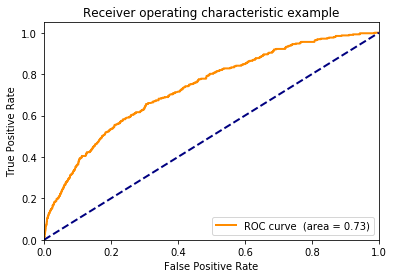

0.7333590508210741

In [25]:
wvpy.util.plot_roc(pf["pred"], pf["churn"])

Notice we dealt with many problem columns at once, and in a statistically sound manner. More on the `vtreat` package for Python can be found here: [https://github.com/WinVector/pyvtreat](https://github.com/WinVector/pyvtreat).  Details on the `R` version can be found here: [https://github.com/WinVector/vtreat](https://github.com/WinVector/vtreat).

We can compare this to the [R solution](https://github.com/WinVector/PDSwR2/blob/master/KDD2009/KDD2009vtreat.md).

We can compare the above cross-frame solution to a naive "design transform and model on the same data set" solution as we show below.  Note we turn off `filter_to_recommended` as this is computed using cross-frame techniques (and hence is a non-naive estimate).

In [26]:
plan_naive = vtreat.BinomialOutcomeTreatment(
    outcome_target=True,              
    params=vtreat.vtreat_parameters({'filter_to_recommended':False}))
plan_naive.fit(d_train, churn_train)
naive_frame = plan_naive.transform(d_train)

In [27]:
fd_naive = xgboost.DMatrix(data=naive_frame, label=churn_train)
x_parameters = {"max_depth":3, "objective":'binary:logistic'}
cvn = xgboost.cv(x_parameters, fd_naive, num_boost_round=100, verbose_eval=False)

In [28]:
bestn = cvn.loc[cvn["test-error-mean"]<= min(cvn["test-error-mean"] + 1.0e-9), :]
bestn

,train-error-mean,train-error-std,test-error-mean,test-error-std
68,0.048421,0.000410,0.056332,0.000472
81,0.046477,0.000702,0.056332,0.000303


In [29]:
ntreen = bestn.index.values[0]
ntreen

68

In [30]:
fittern = xgboost.XGBClassifier(n_estimators=ntreen, max_depth=3, objective='binary:logistic')
fittern

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=68,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [31]:
modeln = fittern.fit(naive_frame, churn_train)

In [32]:
test_processedn = plan_naive.transform(d_test)

In [33]:
pfn = pandas.DataFrame({"churn":churn_test})
predsn = modeln.predict_proba(test_processedn)

In [34]:
pfn["pred_naive"] = predsn[:, 1]

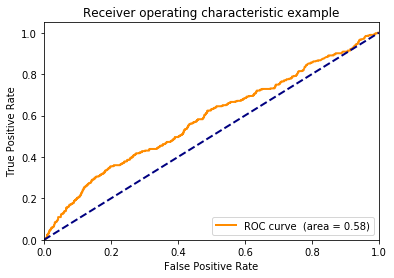

0.583016672624677

In [35]:
wvpy.util.plot_roc(pfn["pred_naive"], pfn["churn"])

Note the naive test performance is worse, despite its far better training performance.  This is over-fit due to the nested model bias of using the same data to build the treatment plan and model without any cross-frame mitigations.